In [1]:
from neo.core import SpikeTrain
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from statannotations.Annotator import Annotator
from tqdm import tqdm
import elephant as eph
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quantities as q
import seaborn as sns
import shutil
import time
import zipfile

import sys
sys.path.append("..")
from utils import *

%config Completer.use_jedi = False

if not os.path.exists('__datacache__'):
    os.makedirs('__datacache__')
if not os.path.exists('AnalysedData'):
    os.makedirs('AnalysedData')

recalculate = False

In [2]:
representative_intermittency = 0.3    

clean_data_cache()
fetch_data(representative_intermittency)

Extracting : 100%|██████████| 501/501 [04:51<00:00,  1.72it/s]


In [3]:
def get_connectivity_timeseries(mat_no,odor_no,replicate):
    n_n = 120
    p_n = 90
    l_n = 30

    pPNPN = 0.0
    pPNLN = 0.1
    pLNPN = 0.2

    ach_mat = np.zeros((n_n,n_n))
    np.random.seed(64163+mat_no) # Random.org
    ach_mat[p_n:,:p_n] = np.random.choice([0.,1.],size=(l_n,p_n),p=(1-pPNLN,pPNLN))
    ach_mat[:p_n,:p_n] = np.random.choice([0.,1.],size=(p_n,p_n),p=(1-pPNPN,pPNPN))
    
    PNLN = ach_mat[p_n:,:p_n]
    
    LNPN = np.zeros((p_n,l_n))
    stride = int(p_n/l_n)
    spread = (round(pLNPN*p_n)//2)*2+1 # Round to closest odd integer
    center = 0
    index = np.arange(p_n)
    for i in range(l_n):
        idx = index[np.arange(center-spread//2,1+center+spread//2)%p_n]
        LNPN[idx,i] = 1
        center+=stride

    fgaba_mat = np.zeros((n_n,n_n))
    fgaba_mat[:p_n,p_n:] = LNPN # LN->PN
    fgaba_mat[p_n:,p_n:] = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=',') # LN->LN
    np.fill_diagonal(fgaba_mat,0.)

    sgaba_mat = np.zeros((n_n,n_n))
    sgaba_mat[:p_n,p_n:] = LNPN
    np.fill_diagonal(sgaba_mat,0.)

    blocktime = 12000 # in ms
    buffer = 500 # in ms
    sim_res = 0.01 # in ms
    min_block = 50 # in ms

    np.random.seed(mat_no+odor_no+replicate)
    sw_state = [0]
    switch_prob = 0.3
    for i in np.random.choice([0,1],p=[1-switch_prob,switch_prob],size=int(blocktime/min_block)-1):
        if i==1:
            sw_state.append(1-sw_state[-1])
        else:
            sw_state.append(sw_state[-1])
    ts = np.repeat(sw_state,int(min_block/sim_res))
    
    sim_time = blocktime + 2*buffer
    t = np.arange(0,sim_time,sim_res)
    np.random.seed(odor_no)
    setpn = np.concatenate([np.ones(9),np.zeros(81)])
    np.random.shuffle(setpn)
    ts = np.concatenate([np.zeros(int(buffer/sim_res)),ts,np.zeros(int(buffer/sim_res))])
    return PNLN,LNPN,setpn,t,ts

def get_traces(mat_no,odor_no,replicate):
    return np.load(f"__datacache__/data_{mat_no}_{odor_no}_{replicate}.npy")

def get_LN_data(mat_no,odor_no,replicate=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    if replicate is None:
        for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir('__datacache__')):
            temp = np.load(f"__datacache__/{i}").T
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    else:
        temp = np.load(f"__datacache__/data_{mat_no}_{odor_no}_{replicate}.npy").T
        spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
        event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
        bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
        pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
        r.append(pearson_correlation[:,order][order,:])
    return np.array(r),mat[:,order][order,:],module[order],order

# Representative PN Traces (Fig 5a) 

In [4]:
PNLN,LNPN,setpn,t,ts = get_connectivity_timeseries(2,59428,1)
v_traces = get_traces(2,59428,1)
LN_correlations,mat,module,order = get_LN_data(2,59428,1)

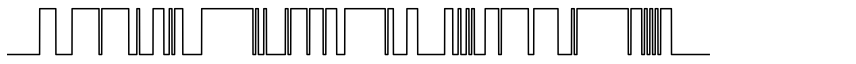

In [5]:
fig,ax = plt.subplots(1,1,figsize=(12,1))
plt.plot(t/1000,ts,'k',linewidth=1.5)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0,15.6)
plt.box(False)
plt.tight_layout()
plt.savefig(f"Figures/IntemittentTimeseries.svg")

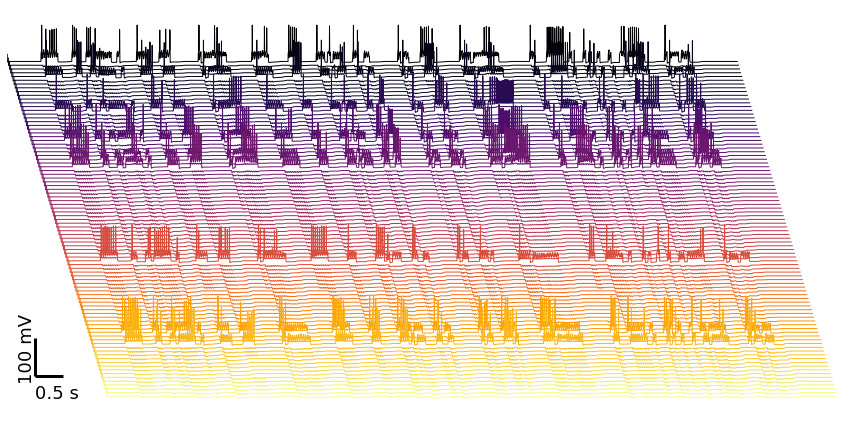

In [6]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
for i in range(90):
    plt.plot(i*0.02+t[::100]/1000,-i*10+np.load("__datacache__/data_2_13674_10.npy")[:,i],linewidth=1,color=plt.cm.inferno(i/90))
plt.hlines(-900,0.5,1.0,color='k',linewidth=3)
plt.vlines(0.5,-900,-800,color='k',linewidth=3)
plt.text(0.5,-960,"0.5 s",fontdict={"fontsize":18})
plt.text(0.2,-910,"100 mV",fontdict={"fontsize":18},rotation=90)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0,15)
plt.box(False)
plt.tight_layout()
plt.savefig(f"Figures/IntemittentPNOutput.svg")

# LN Correlation and Community Reconstruction (Fig 5b,c,d)

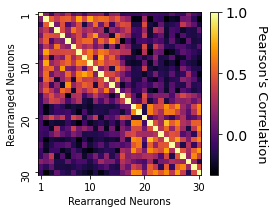

In [7]:
fig = plt.figure(figsize=(4,3))
fig.add_subplot(1,1,1)
mpl.rcParams.update({'font.size': 13})
plt.imshow(LN_correlations.mean(axis=0),cmap=plt.cm.inferno)
plt.xticks([0,9,19,29],[1,10,20,30])
plt.xlabel('Rearranged Neurons')
plt.yticks([0,9,19,29],[1,10,20,30],rotation=90)
plt.ylabel('Rearranged Neurons')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Pearson's Correlation", rotation=270,labelpad=20)
plt.savefig(f"Figures/IntermittentLNStructure.svg")

In [8]:
if recalculate:
    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            LN_correlations,mat,module,order = get_LN_data(i,j)
            for k in range(10):
                correlation = np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat.flatten())[0,1]
                random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
                shuffled = np.mean([np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                results.append((correlation,shuffled))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv("AnalysedData/LNCorrelationAnalysis.csv")
else:
    results = pd.read_csv("AnalysedData/LNCorrelationAnalysis.csv",index_col=0)

In [9]:
eff,(eff_lci,eff_uci)=rankbiserial(results["Original"].values,results["Shuffled"].values)
print(f"{eff:0.3f} [95% CI {eff_lci:0.3f}-{eff_uci:0.3f}]")

1.000 [95% CI 1.000-1.000]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Original vs. Shuffled: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.265e-83 Stat=0.000e+00


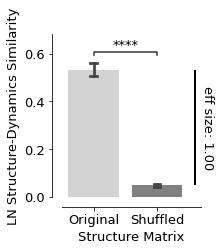

In [10]:
plt.figure(figsize=(2.5,3))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.barplot(data=results,palette='blend:lightgrey,grey',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_xlabel("Structure Matrix")
ax.set_ylabel("LN Structure-Dynamics Similarity")
annotator = Annotator(ax, [("Original", "Shuffled")], data=results)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
plt.vlines(1.6,results["Shuffled"].mean(),results["Original"].mean(),linewidth=2,colors='k')
plt.text(1.7,results.values.mean(),f"eff size: {eff:0.2f}",rotation=270,va='center')
plt.savefig(f"Figures/LNCorrelationAnalysis.svg")

In [11]:
if recalculate:
    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            LN_correlations,mat,module,order = get_LN_data(i,j)
            for k in range(10):
                cluster_model = KMeans(n_clusters=int(np.max(module)))
                cluster_model.fit((1-LN_correlations[k])/2)
                f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
                random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
                shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
                results.append((f_correctpairs,shuffled))
    results = np.array(results)
    results = pd.DataFrame(results,columns=["Newman","Random"])
    results.to_csv("AnalysedData/LNReconstructionAnalysis.csv")
else:
    results = pd.read_csv("AnalysedData/LNReconstructionAnalysis.csv",index_col=0)

In [12]:
eff,(eff_lci,eff_uci)=rankbiserial(results["Newman"].values,results["Random"].values)
print(f"{eff:0.3f} [95% CI {eff_lci:0.3f}-{eff_uci:0.3f}]")

0.953 [95% CI 0.936-0.967]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Newman vs. Random: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.662e-76 Stat=2.969e+03


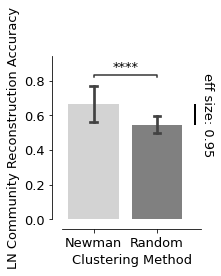

In [13]:
plt.figure(figsize=(2.5,3))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.barplot(data=results,palette='blend:lightgrey,grey',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_xlabel("Clustering Method")
ax.set_ylabel("LN Community Reconstruction Accuracy")
annotator = Annotator(ax, [("Newman","Random")], data=results)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
plt.vlines(1.6,results["Random"].mean(),results["Newman"].mean(),linewidth=2,colors='k')
plt.text(1.7,results.values.mean(),f"eff size: {eff:0.2f}",rotation=270,va='center')
plt.savefig(f"Figures/LNReconstructionAnalysis.svg")

# Odor Specificity of LN dynamics over time (Fig 5e,f)

In [14]:
def odor_analysis(mat_no,time=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    for odor in [13674, 59428, 72957, 84932, 85036]:
        for replicate in range(1,11):
            temp = np.load(f"__datacache__/data_{mat_no}_{odor}_{replicate}.npy").T
            timeseries = np.linspace(0,12.998,12999)
            endpoint = 13*q.s
            if time is not None:
                temp = temp[:,:int(time*1000)]
                endpoint = time*q.s
                timeseries = np.linspace(0,(int(time*1000)-2)/1000,int(time*1000)-1)
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = [SpikeTrain(([0]+list(timeseries[k>0]))*q.s,t_start=0*q.s,t_stop=endpoint) for k in spikes]
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    N = len(r)
    r = np.array(r)
    corr_mat = np.ones((N,N))
    for i in range(N):
        for j in range(i):
            corr_mat[i,j] = pearsonr(r[i].flatten(),r[j].flatten())[0]
            corr_mat[j,i] = corr_mat[i,j]
    summary_matrix = np.zeros((N//10,N//10))
    within = []
    across = []
    for i in range(N//10):
        for j in range(i+1):
            temp = corr_mat[10*i:10*i+10,10*j:10*j+10]
            if i==j:
                summary_matrix[i,j] = np.mean(temp[np.tril_indices(10,-1)])
                within.append(temp[np.tril_indices(10,-1)].flatten())
            else:
                summary_matrix[i,j] = np.mean(temp)
                across.append(temp.flatten())
            summary_matrix[j,i] = summary_matrix[i,j]
    within = np.concatenate(within)
    across = np.concatenate(across)
    return summary_matrix,within[~np.isnan(within)],across[~np.isnan(across)]

In [15]:
if recalculate:
    results= []
    for time in tqdm(np.arange(0.5,13.5,0.5)):
        for i in range(1,11):
            summary_matrix,within,across = odor_analysis(i,time=time)
            for j in within:
                if not np.isnan(j):
                    results.append((time,"Within Odors",j))
            for j in across:
                if not np.isnan(j):
                    results.append((time,"Across Odors",j))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Time","LN Dynamics Correlation","Correlation"])
    results['Time'] = np.float32(results['Time'])
    results['Correlation'] = np.float32(results['Correlation'])
    results.to_csv("AnalysedData/OdorComparisionTimeseries.csv")
else:
    results = pd.read_csv("AnalysedData/OdorComparisionTimeseries.csv",index_col=0)

In [16]:
effectsizes = []
p_values = []
for i in tqdm(np.unique(results['Time'])):
    temp = results[results['Time']==i]
    p_values.append(stats.mannwhitneyu(temp[temp["LN Dynamics Correlation"]=="Within Odors"]["Correlation"].values,
                       temp[temp["LN Dynamics Correlation"]=="Across Odors"]["Correlation"].values).pvalue*500)
    eff,(eff_lci,eff_uci) = cliffdelta(temp[temp["LN Dynamics Correlation"]=="Within Odors"]["Correlation"].values,
                       temp[temp["LN Dynamics Correlation"]=="Across Odors"]["Correlation"].values)
    effectsizes.append((i,eff,eff_lci,eff_uci))
effectsizes = np.array(effectsizes)

100%|██████████| 25/25 [08:15<00:00, 19.80s/it]


<ipython-input-17-68591e52a765>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


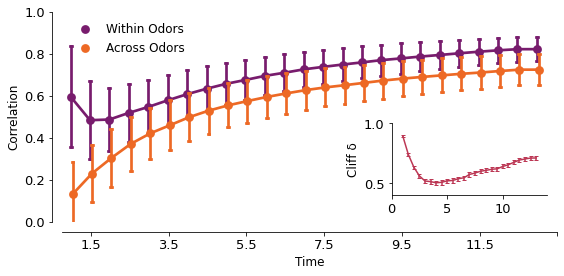

In [17]:
mpl.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(8,4))
g = sns.pointplot(x="Time", y="Correlation", hue="LN Dynamics Correlation",
                  data=results,palette="inferno",ci='sd',capsize=0.1,dodge=0.1)
g.set_ylim(0,1)
g.set_xticks(range(1,26,4))

sns.despine(offset=10, trim=False)
ax2 = fig.add_axes([0.69, 0.3, 0.27, 0.25])
plt.errorbar(x=effectsizes[:,0],y=effectsizes[:,1],
             yerr=(effectsizes[:,1]-effectsizes[:,2],
                   effectsizes[:,3]-effectsizes[:,1]),
             capsize=2,color=plt.cm.inferno(0.5))
ax2.set_ylim(0.4,1)
ax2.set_xlim(0,14)
ax2.set_ylabel("Cliff δ")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

g.legend(loc='upper left',frameon=False)
plt.tight_layout()
plt.savefig(f"Figures/OdorCorrelationTimeseries.svg")

In [23]:
for i in range(len(p_values)):
    print(f"{p_values[i]:0.3e}",end='\t')
print()
for i in range(len(p_values)):
    print("{:0.3f} [95% CI {:0.3f}-{:0.3f}]".format(effectsizes[i,1],effectsizes[i,2],effectsizes[i,3]))

0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	1.399e-304	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	0.000e+00	
0.895 [95% CI 0.887-0.902]
0.741 [95% CI 0.728-0.753]
0.634 [95% CI 0.619-0.649]
0.562 [95% CI 0.545-0.578]
0.520 [95% CI 0.501-0.537]
0.515 [95% CI 0.496-0.532]
0.505 [95% CI 0.486-0.522]
0.509 [95% CI 0.490-0.527]
0.521 [95% CI 0.502-0.539]
0.524 [95% CI 0.506-0.543]
0.539 [95% CI 0.522-0.556]
0.546 [95% CI 0.529-0.564]
0.574 [95% CI 0.557-0.592]
0.586 [95% CI 0.569-0.603]
0.601 [95% CI 0.583-0.618]
0.608 [95% CI 0.592-0.625]
0.617 [95% CI 0.600-0.634]
0.621 [95% CI 0.605-0.638]
0.641 [95% CI 0.625-0.658]
0.655 [95% CI 0.639-0.671]
0.675 [95% CI 0.660-0.691]
0.694 [95% CI 0.679-0.709]
0.703 [95% CI 0.688-0.718]
0.711 [95% CI 0.696-0.725]
0.711 [95% CI 0.697-0.726]


In [24]:
summary_matrix,within,across = odor_analysis(2)

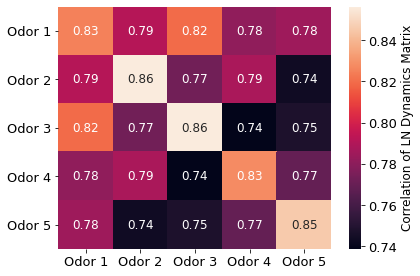

In [25]:
plt.figure(figsize=(6,4))
g = sns.heatmap(summary_matrix,annot=True,cbar_kws={'label': 'Correlation of LN Dynamics Matrix'})
g.set_yticklabels([f"Odor {i}" for i in range(1,6)],rotation=0)
g.set_xticklabels([f"Odor {i}" for i in range(1,6)],rotation=0)
plt.tight_layout()
plt.savefig(f"Figures/Matrix2OdorCorrelation.svg")

# Odor Distance Relationship (Fig 5g)

In [26]:
if recalculate:
    results =[]
    for mat_no in tqdm(range(1,11)):
        random_shuffles = [np.random.choice(np.arange(5),size=5,replace=False) for x in range(1000)]
        LN_inputs = []
        for odor in [13674, 59428, 72957, 84932, 85036]:
            PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor,1)
            LN_inputs.append(PNLN@setpn)
        LN_odor_matrix = distance_matrix(LN_inputs,LN_inputs)
        PN_inputs = []
        for odor in [13674, 59428, 72957, 84932, 85036]:
            PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor,1)
            PN_inputs.append(setpn)
        PN_odor_matrix = distance_matrix(PN_inputs,PN_inputs)
        summary_matrix,_,_ = odor_analysis(mat_no)
        corr_LN = np.corrcoef(summary_matrix[np.tril_indices(5,-1)],LN_odor_matrix[np.tril_indices(5,-1)])[0,1]
        corr_LN_shuffled = np.mean([np.corrcoef(summary_matrix[np.tril_indices(5,-1)],
                                                LN_odor_matrix[:,rs][rs,:][np.tril_indices(5,-1)])[0,1] 
                                    for rs in random_shuffles])
        corr_PN = np.corrcoef(summary_matrix[np.tril_indices(5,-1)],PN_odor_matrix[np.tril_indices(5,-1)])[0,1]
        corr_PN_shuffled = np.mean([np.corrcoef(summary_matrix[np.tril_indices(5,-1)],
                                                PN_odor_matrix[:,rs][rs,:][np.tril_indices(5,-1)])[0,1] 
                                    for rs in random_shuffles])
        results.append((corr_LN_shuffled,corr_LN,corr_PN,corr_PN_shuffled))
    results=np.abs(np.array(results))
    results = pd.DataFrame(results,columns=["LN Input\n(Shuffled)","LN Input","PN Input","PN Input\n(Shuffled)"])
    results.to_csv("AnalysedData/OdorStructureComparison.csv")
else:
    results = pd.read_csv("AnalysedData/OdorStructureComparison.csv",index_col=0)

In [27]:
effLN,(effLN_lci,effLN_uci)=cliffdelta(results["LN Input"].values,results["LN Input\n(Shuffled)"].values)
print(f"{effLN:0.3f} [95% CI {effLN_lci:0.3f}-{effLN_uci:0.3f}]")

1.000 [95% CI 1.000-1.000]


In [28]:
effPN,(effPN_lci,effPN_uci)=cliffdelta(results["PN Input"].values,results["PN Input\n(Shuffled)"].values)
print(f"{effPN:0.3f} [95% CI {effPN_lci:0.3f}-{effPN_uci:0.3f}]")

1.000 [95% CI 1.000-1.000]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LN Input
(Shuffled) vs. LN Input: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00
PN Input vs. PN Input
(Shuffled): Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.859e-03 Stat=0.000e+00
LN Input vs. PN Input: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.973e-01 Stat=1.500e+01


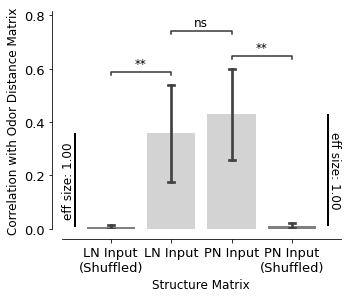

In [29]:
plt.figure(figsize=(5,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.barplot(data=results,palette='blend:grey,lightgrey,lightgrey,grey',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_xlabel("Structure Matrix")
ax.set_ylabel("Correlation with Odor Distance Matrix")
annotator = Annotator(ax, [("LN Input\n(Shuffled)","LN Input"),
                           ("PN Input\n(Shuffled)","PN Input"),
                           ("LN Input","PN Input")], data=results)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
plt.vlines(-0.6,results["LN Input\n(Shuffled)"].mean(),results["LN Input"].mean(),linewidth=2,colors='k')
plt.text(-0.8,np.nanmean(results[["LN Input\n(Shuffled)","LN Input"]].values),
         f"eff size: {effLN:0.2f}",rotation=90,va='center')
plt.vlines(3.6,results["PN Input\n(Shuffled)"].mean(),results["PN Input"].mean(),linewidth=2,colors='k')
plt.text(3.6,np.nanmean(results[["PN Input\n(Shuffled)","PN Input"]].values),
         f"eff size: {effPN:0.2f}",rotation=270,va='center')
plt.savefig(f"Figures/OdorStructureAnalysis.svg")

# PN Structure Dynamics Relationship (Fig 6)

In [32]:
def get_module_vector(pn,LNPN=LNPN,module=module,order=order):
    temp = module[(LNPN[pn,:]==1)]
    vec = np.zeros(int(np.max(module)))
    for i in range(1,int(np.max(module))+1):
        vec[i-1] = np.sum(temp==i)
    return vec
    
def get_PN_data(mat_no,odor_no,replicate=None):
    spike_dist = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor_no,1)
    module_space = [get_module_vector(i,LNPN=LNPN,module=module,order=order) for i in np.arange(90)[setpn==1]]
    module_dist = distance_matrix(module_space,module_space)
    for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir('__datacache__')):
        temp = np.load(f"__datacache__/{i}").T
        spikes = np.logical_and(temp[:90,1:]>=0.,temp[:90,:-1]<0.)
        event = [SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes[np.arange(90)[setpn==1]]]
        distance = eph.spike_train_dissimilarity.van_rossum_dist(event,tau=50*q.ms)
        spike_dist.append(distance)
    return np.array(spike_dist),module_dist

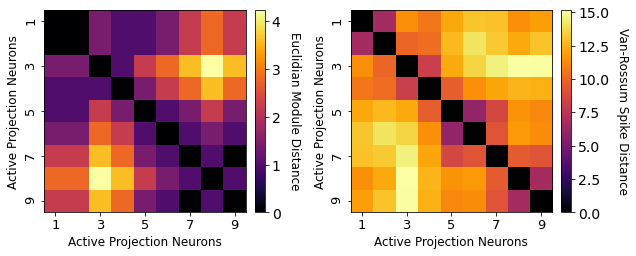

In [33]:
spike_dist,module_dist = get_PN_data(2,59428)
fig = plt.figure(figsize=(9,4))
fig.add_subplot(1,2,2)
plt.imshow(spike_dist.mean(axis=0),cmap=plt.cm.inferno)
plt.xticks([0,2,4,6,8],[1,3,5,7,9])
plt.xlabel('Active Projection Neurons')
plt.yticks([0,2,4,6,8],[1,3,5,7,9],rotation=90)
plt.ylabel('Active Projection Neurons')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Van-Rossum Spike Distance", rotation=270,labelpad=20)
fig.add_subplot(1,2,1)
plt.imshow(module_dist,cmap=plt.cm.inferno)
plt.xticks([0,2,4,6,8],[1,3,5,7,9])
plt.xlabel('Active Projection Neurons')
plt.yticks([0,2,4,6,8],[1,3,5,7,9],rotation=90)
plt.ylabel('Active Projection Neurons')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Euclidian Module Distance", rotation=270,labelpad=20)
plt.tight_layout()
plt.savefig(f"Figures/PNCorrelation.svg")

In [34]:
if recalculate:
    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            spike_dist,module_dist = get_PN_data(i,j)
            for k in range(10):
                correlation = np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist.flatten())[0,1]
                random_shuffles = [np.random.choice(np.arange(9),size=9,replace=False) for x in range(1000)]
                shuffled = np.mean([np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                results.append((correlation,shuffled))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv("AnalysedData/PNCorrelationAnalysis.csv")
else:
    results = pd.read_csv("AnalysedData/PNCorrelationAnalysis.csv",index_col=0)

In [35]:
eff,(eff_lci,eff_uci)=rankbiserial(results["Original"].values,results["Shuffled"].values)
print(f"{eff:0.3f} [95% CI {eff_lci:0.3f}-{eff_uci:0.3f}]")

0.981 [95% CI 0.972-0.989]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Original vs. Shuffled: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.414e-80 Stat=1.179e+03


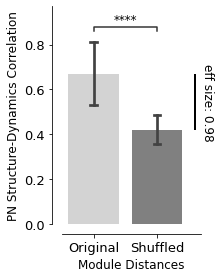

In [36]:
plt.figure(figsize=(2.5,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.barplot(data=results,palette='blend:lightgrey,grey',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_xlabel("Module Distances")
ax.set_ylabel("PN Structure-Dynamics Correlation")
annotator = Annotator(ax, [("Original", "Shuffled")], data=results)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
plt.vlines(1.6,results["Shuffled"].mean(),results["Original"].mean(),linewidth=2,colors='k')
plt.text(1.7,results.values.mean(),f"eff size: {eff:0.2f}",rotation=270,va='center')
plt.savefig(f"Figures/PNCorrelationAnalysis.svg")